<!-- Autogenerated by `scripts/make_examples.py` -->
<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/voxel51/fiftyone-examples/blob/master/examples\football_player_segmentation.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791629-6e618700-5769-11eb-857f-d176b37d2496.png" height="32" width="32">
            Try in Google Colab
        </a>
    </td>
    <td>
        <a target="_blank" href="https://nbviewer.jupyter.org/github/voxel51/fiftyone-examples/blob/master/examples\football_player_segmentation.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791634-6efa1d80-5769-11eb-8a4c-71d6cb53ccf0.png" height="32" width="32">
            Share via nbviewer
        </a>
    </td>
    <td>
        <a target="_blank" href="https://github.com/voxel51/fiftyone-examples/blob/master/examples\football_player_segmentation.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791633-6efa1d80-5769-11eb-8ee3-4b2123fe4b66.png" height="32" width="32">
            View on GitHub
        </a>
    </td>
    <td>
        <a href="https://github.com/voxel51/fiftyone-examples/raw/master/examples\football_player_segmentation.ipynb" download>
            <img src="https://user-images.githubusercontent.com/25985824/104792428-60f9cc00-576c-11eb-95a4-5709d803023a.png" height="32" width="32">
            Download notebook
        </a>
    </td>
</table>


## Exploring Football Player Segmentation dataset and using Segment Anything Model for prediction of segmentations
In this notebook, we will be exploring the [football player segmentation](https://www.kaggle.com/datasets/ihelon/football-player-segmentation
) dataset. The notebook goes through steps of loading the dataset, filtering and using [FiftyOne Brain](https://docs.voxel51.com/user_guide/brain.html) similarity method to find images of different scenarios on during a football game. In the final step, [Segment Anything Model](https://github.com/facebookresearch/segment-anything) is used for predicting segmentations on a subset of dataset and evaluate the predictions against ground_truth

Run the below code cell to get the required python libraries and restart the notebook

In [ ]:
# !pip install -U fiftyone
# !pip install pycocotools
# !pip install fiftyone umap-learn
# !pip install kaggle
# !pip install torchvision 
# !pip install wget
# !pip install opencv-python
# !pip install shapely
# !pip install git+https://github.com/facebookresearch/segment-anything.git

## Import

In [2]:
import fiftyone as fo
import fiftyone.brain as fob
from fiftyone import ViewField as F
import os
import cv2
import wget
import matplotlib.pyplot as plt
from zipfile import ZipFile
import torch
import torchvision
import numpy as np
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import PIL

## Get current working directory

In [3]:
# Get the current working directory
cwd = os.path.abspath(os.getcwd())

## Download and Extract Dataset from Kaggle

1.   If you are not a Kaggle user, you will first need to create a Kaggle account. After creation of the account, go to your Kaggle Account page and scroll down to API section.
2.   Click on Create New API Token. A new API token in the form of kaggle.json file will be created which you can save locally. The kaggle.json file contains your Kaggle username and key.
3. Download the kaggle.json file to your current working directory

In [ ]:
os.environ['KAGGLE_CONFIG_DIR']=cwd

# Download the dataset
!kaggle datasets download -d ihelon/football-player-segmentation

# Extract the dataset to the current working directory
!unzip football-player-segmentation.zip

## Load the dataset
The football player segmentation dataset is already formatted to COCO dataset format, therefore we can import the dataset using fo.types.COCODetectionDataset

In [4]:
# The directory containing the source images
data_path = "./images"

# The path to the COCO labels JSON file
labels_path = "./annotations/instances_default.json"

# name of dataset
name = "football-player-segmentation"

# Import the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path,
    name=name
)
dataset.compute_metadata()

 100% |█████████████████| 512/512 [29.4s elapsed, 0s remaining, 21.7 samples/s]      


## Add Embeddings
We are going to use [FiftyOne Brain's embedding similarity capabaility](https://docs.voxel51.com/user_guide/brain.html#brain-similarity) to visualize some scenarios in a football game.

In [ ]:
fob.compute_visualization(
    dataset,
    model="clip-vit-base32-torch",
    brain_key="img_sim",
)


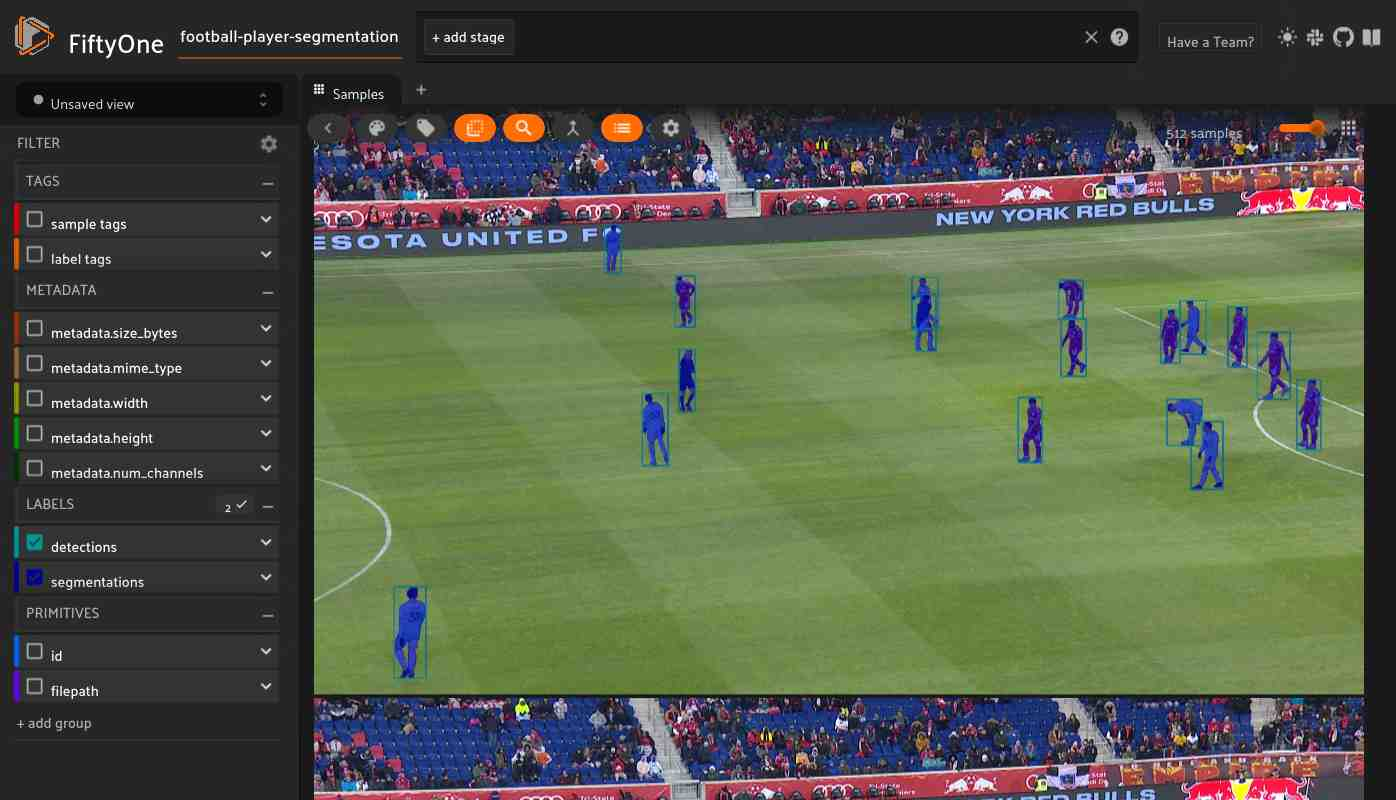

In [6]:
session = fo.launch_app(dataset=dataset)

In [7]:
session.freeze()

## Filter by detection field


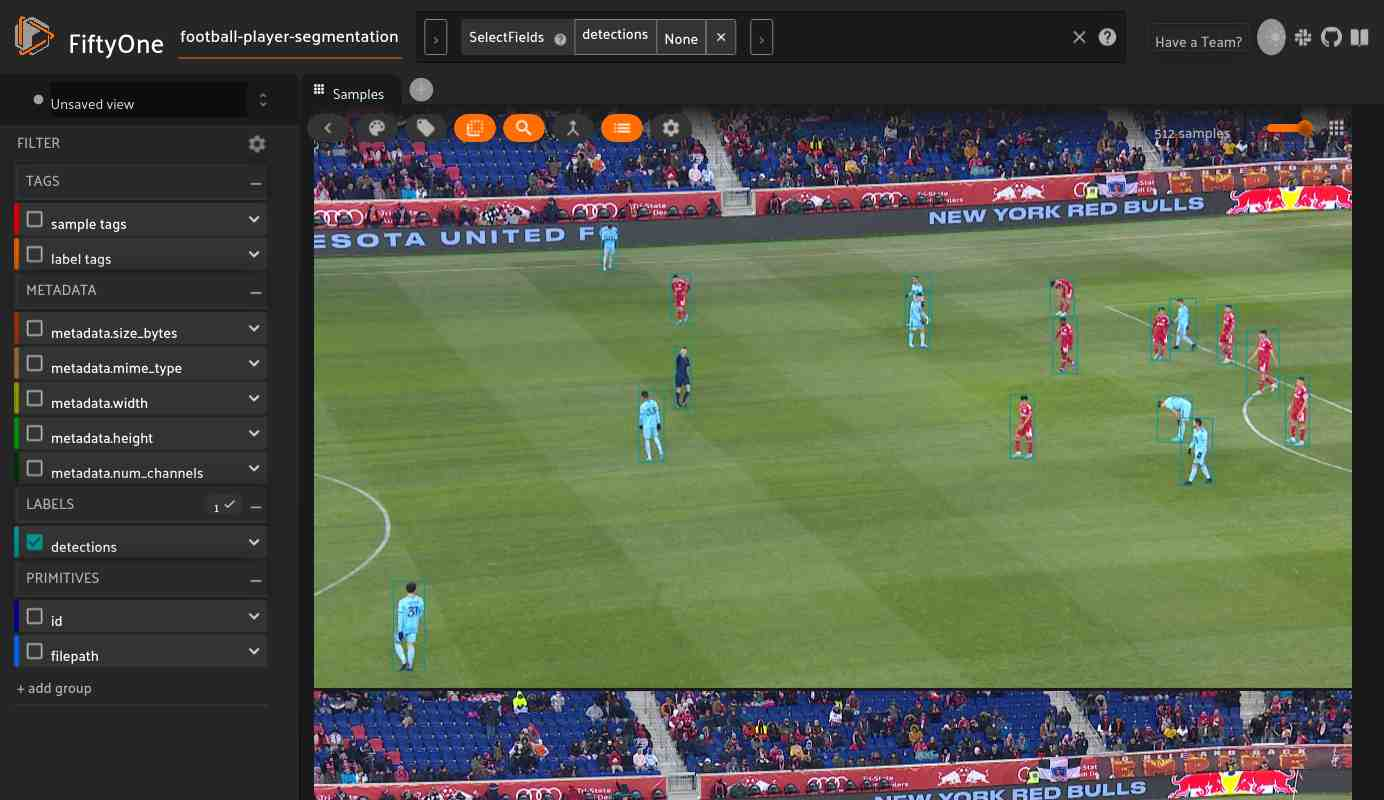

In [11]:
detection_view = dataset.select_fields('detections')
session.view=detection_view

In [12]:
session.freeze()

## Filter by segmentations field


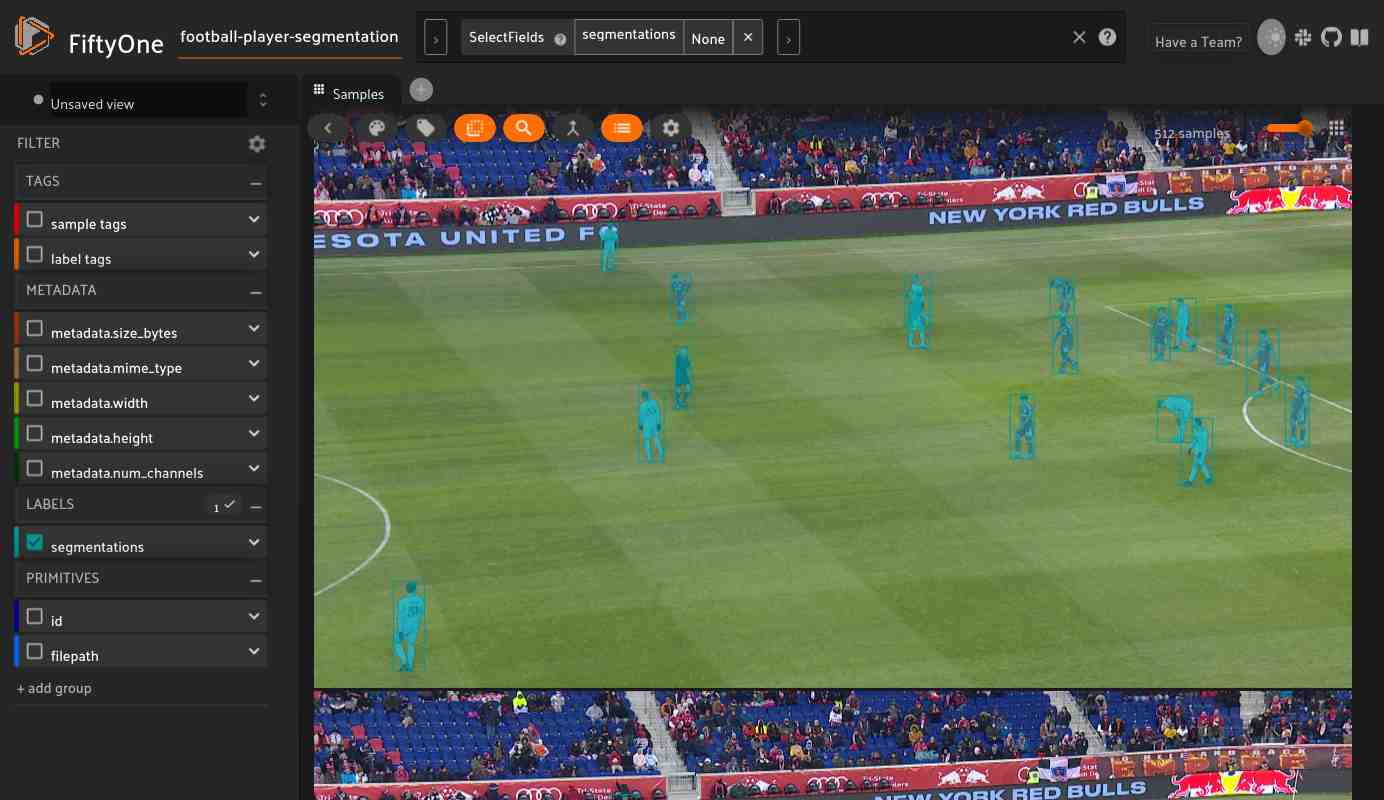

In [13]:
segmentation_view = dataset.select_fields('segmentations')
session.view=segmentation_view

In [14]:
session.freeze()

## Filtering by id
In the following case, filtering different persons detected in an image. We have filtered the referee in the below view


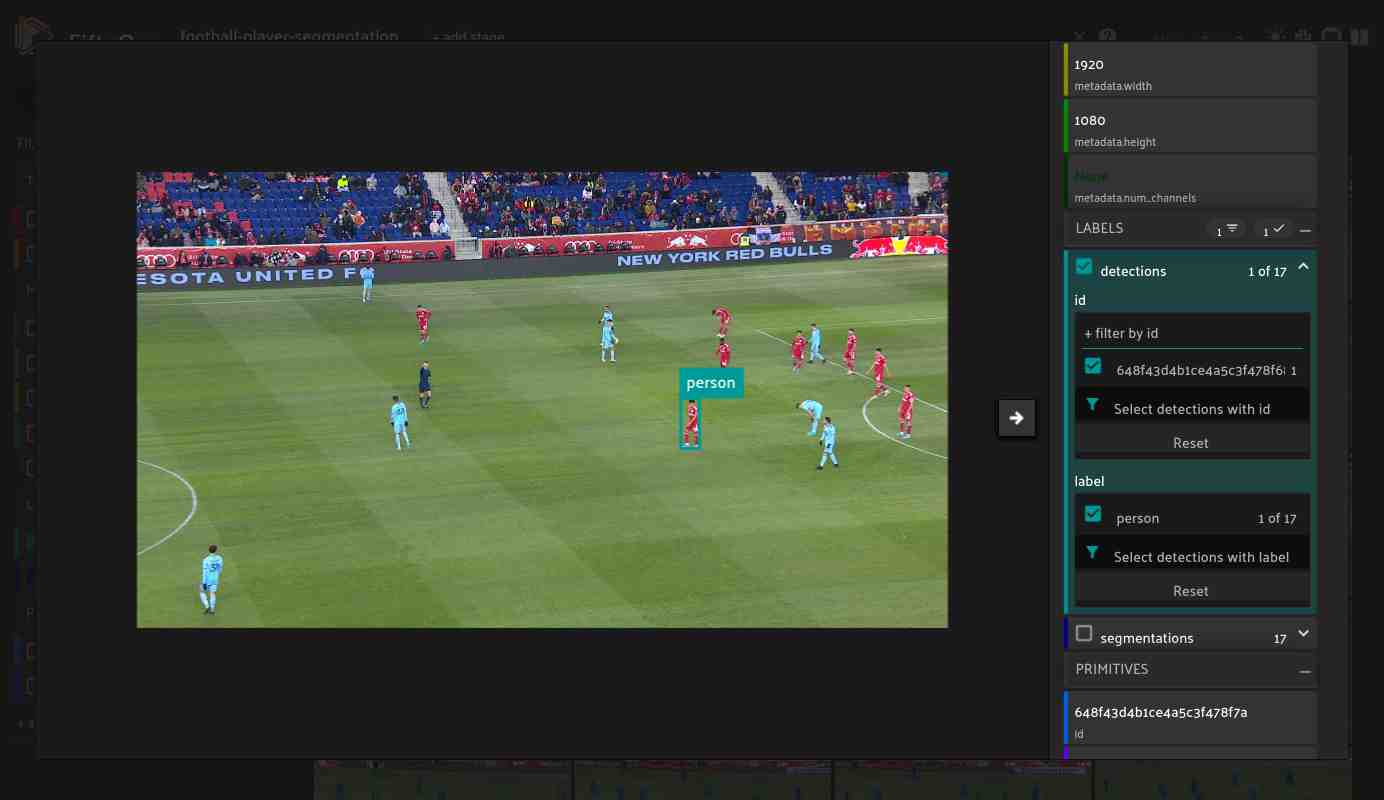

In [17]:
session.view=None

In [18]:
session.freeze()

## Embeddings - Similarity

Let's check out some different scenarios by selecting different clusters in the embeddings

In [ ]:
session.view=None

<img src="gifs/embeddings_1.gif">

The above cluster with lasso selection shows 13 samples of what looks like positions of footballers during a corner kick at a certain side. This set of similar images helps to track the positions of the players before and after the kick and similar clusters can be used to analyse the player tracking for other corner kicks taken on same and opposite sides during the game.

In [ ]:
session.view = None

<img src="gifs/embeddings_2.gif">

In the second cluster lasso selection, set of similar images show the player positions during a throw-in

## Let's add segmentations predictions to subset of dataset with the help of SAM and evaluate them against ground_truths

### Download the Segment Anything Model

In [7]:
# Create a new directory named 'model'
os.mkdir(cwd+'/model')

checkpoint = "sam_vit_b_01ec64.pth"
model_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
model_type = "default"

# Set the path to the checkpoint
checkpoint_path = cwd+'/model/sam_vit_h_4b8939.pth'

# Download the files to their respective paths
wget.download(model_url, out = checkpoint_path)

### Create predictions view from a subset of dataset

In [14]:
predictions_view = dataset.take(30)


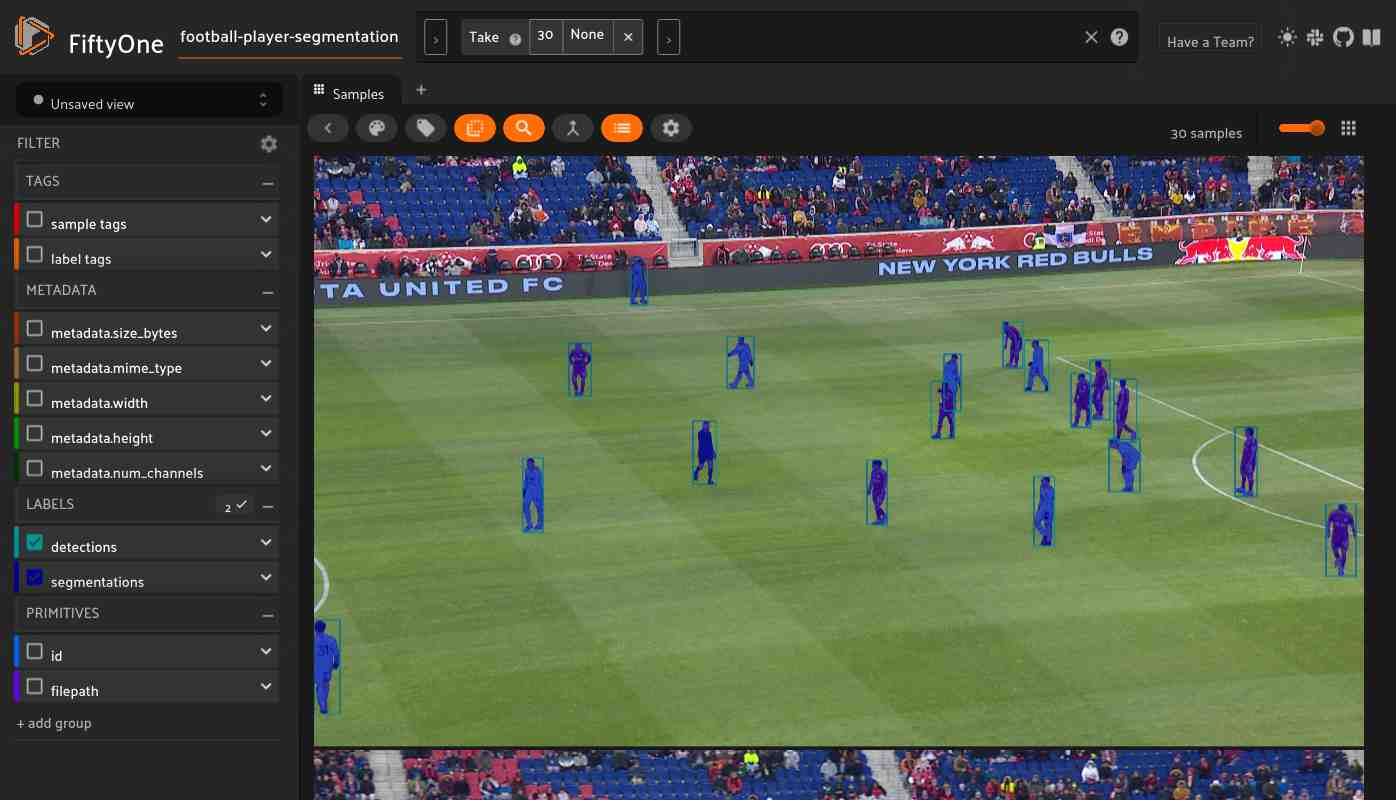

In [15]:
session.view=predictions_view

In [16]:
session.freeze()

### Load SAM model and predictor

In [12]:
# Set path to the checkpoint running on CPU
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam.to(device)
# Instantiate SAM predictor model
predictor = SamPredictor(sam)

Since we have the bounding box available from detection, we can use the bounding boxes to generate segmentation masks. Detailed explanation on the code and instance segmentation with SAM can be found in this [article](https://towardsdatascience.com/see-what-you-sam-4eea9ad9a5de#37d5) written by Jacob Marks

In [13]:
# Converts from fiftyone relative coordinates to absolute
def fo_to_sam(box, img_width, img_height):
    new_box = np.copy(np.array(box))
    new_box[0] *= img_width
    new_box[2] *= img_width
    new_box[1] *= img_height
    new_box[3] *= img_height
    new_box[2] += new_box[0]
    new_box[3] += new_box[1]
    return np.round(new_box).astype(int)

def add_SAM_mask_to_detection(detection, mask, img_width, img_height):
    y0, x0, y1, x1 = fo_to_sam(detection.bounding_box, img_width, img_height)    
    mask_trimmed = mask[x0:x1+1, y0:y1+1]
    detection["mask"] = np.array(mask_trimmed)
    return detection

def add_SAM_instance_segmentation(sample):
    w, h = sample.metadata.width, sample.metadata.height
    image = np.array(PIL.Image.open(sample.filepath))
    # process the image to produce an image embedding
    predictor.set_image(image)
    
    if sample.detections is None:
        return

    dets = sample.detections.detections
    boxes = [d.bounding_box for d in dets]
    sam_boxes = np.array([fo_to_sam(box, w, h) for box in boxes])
    
    input_boxes = torch.tensor(sam_boxes, device=predictor.device)
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
    
    masks, _, _ = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )
    
    new_dets = []
    for i, det in enumerate(dets):
        mask = masks[i, 0]
        new_dets.append(add_SAM_mask_to_detection(det, mask, w, h))

    sample['predictions'] = fo.Detections(detections = new_dets)
    sample.save()    

def add_SAM_instance_segmentations(dataset):
    for sample in dataset.iter_samples(autosave=True, progress=True):
        add_SAM_instance_segmentation(sample)      

In [14]:
add_SAM_instance_segmentations(predictions_view) 

 100% |███████████████████| 30/30 [15.7m elapsed, 0s remaining, 0.0 samples/s]    



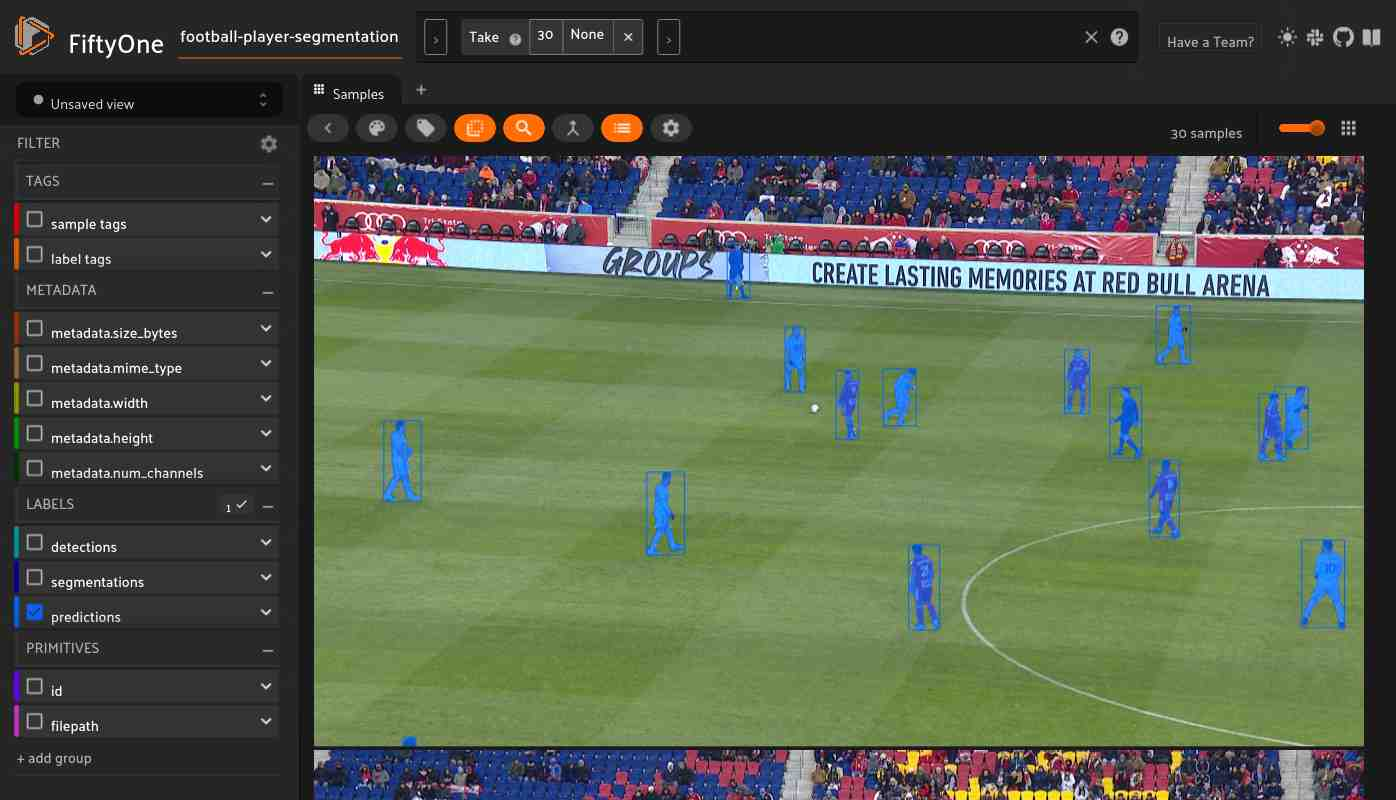

In [15]:
session.view = predictions_view

In [16]:
session.freeze()

### Evaluate predictions

In [24]:
results = predictions_view.evaluate_detections(
    "predictions", gt_field="segmentations", eval_key="eval", use_masks = True
)

Evaluating detections...
 100% |███████████████████| 30/30 [8.3s elapsed, 0s remaining, 3.9 samples/s]       


In [25]:
# Convert to evaluation patches
eval_patches = predictions_view.to_evaluation_patches("eval")
print(eval_patches)

Dataset:     football-player-segmentation
Media type:  image
Num patches: 438
Patch fields:
    id:            fiftyone.core.fields.ObjectIdField
    sample_id:     fiftyone.core.fields.ObjectIdField
    filepath:      fiftyone.core.fields.StringField
    tags:          fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    segmentations: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    predictions:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    crowd:         fiftyone.core.fields.BooleanField
    type:          fiftyone.core.fields.StringField
    iou:           fiftyone.core.fields.FloatField
View stages:
    1. Take(size=30, seed=None)
    2. ToEvaluationPatches(eval_key='eval', config=None)


In [26]:
print(eval_patches.count_values("type"))

{'fn': 9, 'fp': 9, 'tp': 420}



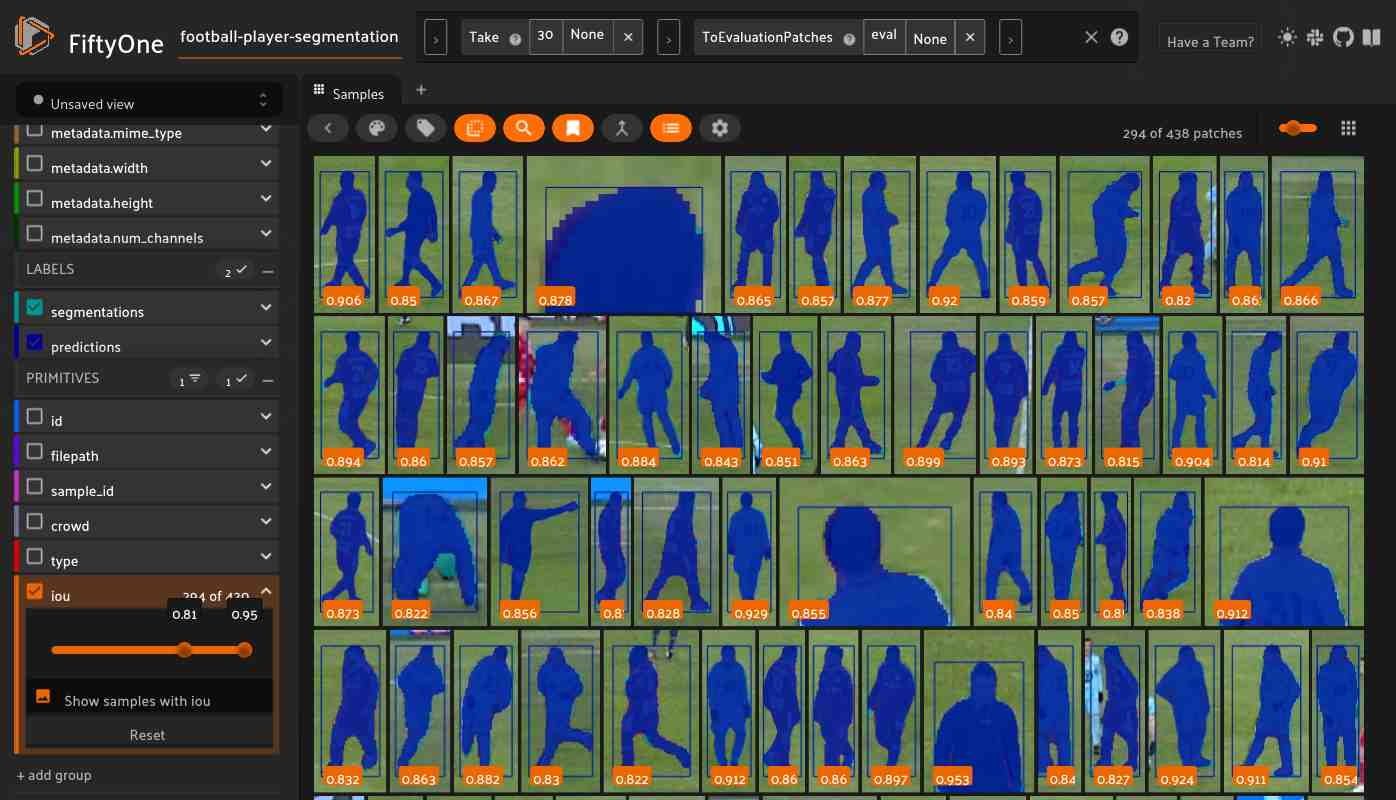

In [23]:
# View patches in the App
session.view = eval_patches

In [27]:
session.freeze()